# Memory on this machine

In [ ]:
import psutil
import subprocess

# Get the total RAM in bytes
total_ram = psutil.virtual_memory().total

# Convert bytes to GB
total_ram_gb = total_ram / (1024 ** 3)

print(f"Total RAM:\n{total_ram_gb:.2f} GB")

# Run nvidia-smi and capture the output
result = subprocess.run(['nvidia-smi', '--query-gpu=memory.total', '--format=csv'], stdout=subprocess.PIPE)
output = result.stdout.decode('utf-8')

# Print the output
print("GPU Memory Capacity:")
print(output)

CUDA environment variables.

In [ ]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64'

# Imports

In [ ]:
!pip install numpy==1.26.4
!python -m cupyx.tools.install_library --cuda 12.x --library cutensor
!pip install cupy-cuda12x
!pip install 'spacy[transformers]'
# !python -m spacy download en_core_web_trf 
# !python -m spacy download cs_core_web_trf
!python -m spacy download xx_ent_wiki_sm

In [ ]:
import datasets
import spacy
import traceback
from tqdm import tqdm
from datasets import DatasetDict
from spacy import displacy
from spacy.tokens import Doc, DocBin
from pathlib import Path

# Helper Functions

Loads a dataset and splits it to train, test and validation parts.

In [ ]:
def load_and_split_ds(path, name, test_size=0.2):
    ds = datasets.load_dataset(path, name)
    ds_split_1 = ds['train'].train_test_split(test_size=test_size)

    if 'validation' in ds:
        return DatasetDict({
            'train': ds_split_1['train'],
            'dev': ds_split_1['test'],
            'validation': ds['validation']})
    else:
        ds_split_2 = ds_split_1['test'].train_test_split(test_size=0.5)
        return DatasetDict({
            'train': ds_split_1['train'],
            'dev': ds_split_2['test'],
            'validation': ds_split_2['train']})

Recongnises entities and visualizes the result using the specified model.

In [ ]:
def visualize_entities(text, model):
    displacy.render(model(text), style='ent', jupyter=True)

Converters to the format for named entity regognition.

In [ ]:
# def convert_row_to_ner_format(row):
#     entity_list = []
#     for anchor in row["paragraph_anchors"]:
#         start = anchor.get("start")
#         end = anchor.get("end")
#         label = anchor.get("title")
#         if None not in (start, end, label):
#             entity_list.append({
#                 "start": start,
#                 "end": end,
#                 "label": label,
#             })
#     return {
#         "text": row["paragraph_text"],
#         "entities": entity_list  # now a list of dicts
#     }


def convert_row_to_ner_format(row):
    entities = []
    for anchor in row['paragraph_anchors']:
        # get the offsets (could be string, float, etc.)
        start_raw = anchor.get('start')
        end_raw = anchor.get('end')
        label = anchor.get('title')

        # skip if any are None
        if start_raw is None or end_raw is None or label is None:
            continue

        # ensure these are actually integers
        try:
            start = int(start_raw)
            end = int(end_raw)
        except ValueError:
            # if you can't convert them to int, skip or handle differently
            print(f"start_raw={start_raw}, type(start_raw)={type(start_raw)}")
            print(f"start_raw={end_raw}, type(start_raw)={type(end_raw)}")
            continue

        entities.append({
            "start": start,
            "end": end,
            "label": label,
        })

    data_point = {
        "text": row["paragraph_text"],
        "entities": entities,
    }
    return data_point


def convert_dataset_to_ner_format(dataset):
    """
    Converts a dataset to NER format using dataset.map().
    """
    # Use map to process the dataset
    ner_dataset = dataset.map(convert_row_to_ner_format)
    print(f"ner_dataset[0]={ner_dataset[0]}")
    return ner_dataset

Doc file creator for SpaCy.

In [ ]:
# def create_spacy_doc_bin_file(dataset, file_name, language):
#     nlp = spacy.blank(language)
#     db = DocBin()
#     for i in tqdm(range(0, len(dataset))):
#         datum = dataset[i]
#         text = datum['text']
#         doc = nlp(text)
#         ents = []
#         for start, end, label in datum.get('entities'):
#             span = doc.char_span(start, end, label=label)
#             ents.append(span)
#         doc.ents = ents
#         db.add(doc)
#     db.to_disk(file_name)

In [ ]:
def create_spacy_doc_bin_files(dataset, output_dir, file_name, language, chunk_size=2000):
    """
    Create multiple SpaCy DocBin files to avoid loading the entire structure into memory.

    Args:
        dataset (list): A list of dictionaries containing text and entity information.
        output_dir (str): Directory where the output files will be saved.
        language (str): Language code for the SpaCy model (e.g., "en").
        chunk_size (int): Number of documents to process in each file.
    """
    import os
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    nlp = spacy.blank(language)
    total_docs = len(dataset)
    file_index = 0

    for i in tqdm(range(0, total_docs, chunk_size)):
        db = DocBin()
        for j in range(i, min(i + chunk_size, total_docs)):
            datum = dataset[j]
            text = datum['text']
            doc = nlp(text)
            ents = []
            for entities in datum.get('entities', []):
                start_raw = entities.get('start')
                end_raw = entities.get('end')
                label = entities.get('label')
                
                # skip if any are None
                if start_raw is None or end_raw is None or label is None:
                    continue
        
                # ensure these are actually integers
                try:
                    start = int(start_raw)
                    end = int(end_raw)
                except ValueError:
                    # if you can't convert them to int, skip or handle differently
                    print(f"start_raw={start_raw}, type(start_raw)={type(start_raw)}")
                    print(f"start_raw={end_raw}, type(start_raw)={type(end_raw)}")
                    continue
                    
                span = doc.char_span(start, end, label=label)
                if span is not None:
                    ents.append(span)

            # Discard overlapping entities and keep the longest one
            ents = sorted(ents, key=lambda x: (x.start, -x.end + x.start))
            filtered_ents = []
            for ent in ents:
                if not filtered_ents or ent.start >= filtered_ents[-1].end:
                    filtered_ents.append(ent)

            try:
                doc.ents = filtered_ents
            except ValueError as ex:
                print(f"ValueError raised.")
                print(f"filtered_ents={filtered_ents}, text={text}")
                raise ex
            db.add(doc)
        
        # Save the chunk to a new file
        output_file = os.path.join(output_dir, f'{file_name}{file_index + 1}.spacy')
        db.to_disk(output_file)
        file_index += 1


# Load Datasets

English

In [ ]:
#en_ds = load_and_split_ds('wikimedia/wikipedia', '20231101.en')
en_ds = load_and_split_ds('cyanic-selkie/wikianc', 'en')
en_ds['train'][0]

Czech

In [ ]:
# cs_ds = load_and_split_ds('wikimedia/wikipedia', '20231101.cs')
# cs_ds['train'][0]

Hungarian

In [ ]:
# hu_ds = load_and_split_ds('wikimedia/wikipedia', '20231101.hu')
# hu_ds['train'][0]

Ukrainian

In [ ]:
# en_uk = load_and_split_ds('wikimedia/wikipedia', '20231101.uk')
# en_uk['train'][0]

# SpaCy Built-In Entity Types
<!-- - **PERSON** - People, including fictional.
- **NORP** - Nationalities or religious or political groups.
- **FAC** - Buildings, airports, highways, bridges, etc.
- **ORG** - Companies, agencies, institutions, etc.
- **GPE** - Countries, cities, states.
- **LOC** - Non-GPE locations, mountain ranges, bodies of water.
- **PRODUCT** - Objects, vehicles, foods, etc. (Not services.)
- **EVENT** - Named hurricanes, battles, wars, sports events, etc.
- **WORK_OF_ART** - Titles of books, songs, etc.
- **LAW** - Named documents made into laws.
- **LANGUAGE** - Any named language.
- **DATE** - Absolute or relative dates or periods.
- **TIME** - Times smaller than a day.
- **PERCENT** - Percentage, including "%".
- **MONEY** - Monetary values, including unit.
- **QUANTITY** - Measurements, as of weight or distance.
- **ORDINAL** - "first", "second", etc.
- **CARDINAL** - Numerals that do not fall under another type.-->
- **LOC** - Countries, cities, states, mountain ranges, bodies of water.
- **ORG** - Companies, agencies, institutions, etc.
- **PER** - People, including fictional.
- **MISC** - Other categories.

# SpaCy Transformers off the Shelf Model

## English

Sample text for testing.

In [ ]:
en_text = """
World War II[b] or the Second World War (1 September 1939 – 2 September 1945) was a global conflict between two coalitions: the Allies and the Axis powers. Nearly all the world's countries—including all the great powers—participated, with many investing all available economic, industrial, and scientific capabilities in pursuit of total war, blurring the distinction between military and civilian resources. Tanks and aircraft played major roles, with the latter enabling the strategic bombing of population centres and delivery of the only two nuclear weapons ever used in war. World War II was the deadliest conflict in history, resulting in 70 to 85 million deaths, more than half being civilians. Millions died in genocides, including the Holocaust of European Jews, as well as from massacres, starvation, and disease. Following the Allied powers' victory, Germany, Austria, Japan, and Korea were occupied, and war crimes tribunals were conducted against German and Japanese leaders.
The causes of World War II included unresolved tensions in the aftermath of World War I and the rise of fascism in Europe and militarism in Japan. Key events leading up to the war included Japan's invasion of Manchuria, the Spanish Civil War, the outbreak of the Second Sino-Japanese War, and Germany's annexations of Austria and the Sudetenland. World War II is generally considered to have begun on 1 September 1939, when Nazi Germany, under Adolf Hitler, invaded Poland, prompting the United Kingdom and France to declare war on Germany. Poland was divided between Germany and the Soviet Union under the Molotov–Ribbentrop Pact, in which they had agreed on "spheres of influence" in Eastern Europe. In 1940, the Soviets annexed the Baltic states and parts of Finland and Romania. After the fall of France in June 1940, the war continued mainly between Germany and the British Empire, with fighting in the Balkans, Mediterranean, and Middle East, the aerial Battle of Britain and the Blitz, and naval Battle of the Atlantic. Through a series of campaigns and treaties, Germany took control of much of continental Europe and formed the Axis alliance with Italy, Japan, and other countries. In June 1941, Germany led the European Axis in an invasion of the Soviet Union, opening the Eastern Front and initially making large territorial gains.
Japan aimed to dominate East Asia and the Asia-Pacific, and by 1937 was at war with the Republic of China. In December 1941, Japan attacked American and British territories in Southeast Asia and the Central Pacific, including Pearl Harbor in Hawaii, which resulted in the US and the UK declaring war against Japan, and the European Axis declaring war on the US. Japan conquered much of coastal China and Southeast Asia, but its advances in the Pacific were halted in mid-1942 after its defeat in the naval Battle of Midway; Germany and Italy were defeated in North Africa and at Stalingrad in the Soviet Union. Key setbacks in 1943—including German defeats on the Eastern Front, the Allied invasions of Sicily and the Italian mainland, and Allied offensives in the Pacific—cost the Axis powers their initiative and forced them into strategic retreat on all fronts. In 1944, the Western Allies invaded German-occupied France at Normandy, while the Soviet Union regained its territorial losses and pushed Germany and its allies westward. At the same time, Japan suffered reversals in mainland Asia, while the Allies crippled the Japanese Navy and captured key islands.
The war in Europe concluded with the liberation of German-occupied territories; the invasion of Germany by the Western Allies and the Soviet Union, culminating in the fall of Berlin to Soviet troops; Hitler's suicide; and the German unconditional surrender on 8 May 1945. Following the refusal of Japan to surrender on the terms of the Potsdam Declaration, the US dropped the first atomic bombs on Hiroshima and Nagasaki on 6 and 9 August. Faced with an imminent invasion of the Japanese archipelago, the possibility of further atomic bombings, and the Soviet declaration of war against Japan and its invasion of Manchuria, Japan announced its unconditional surrender on 15 August and signed a surrender document on 2 September 1945, marking the end of the war.
World War II changed the political alignment and social structure of the world, and it set the foundation of international relations for the rest of the 20th century and into the 21st century. The United Nations was established to foster international cooperation and prevent conflicts, with the victorious great powers—China, France, the Soviet Union, the UK, and the US—becoming the permanent members of its security council. The Soviet Union and the United States emerged as rival superpowers, setting the stage for the Cold War. In the wake of European devastation, the influence of its great powers waned, triggering the decolonisation of Africa and Asia. Most countries whose industries had been damaged moved towards economic recovery and expansion.
"""

Testing the off the shelf model.

In [ ]:
visualize_entities(en_text, spacy.load('xx_ent_wiki_sm'))

## Czech

In [ ]:
# cs_text = """
# Druhá světová válka byl globální vojenský konflikt v letech 1939–1945, jehož se zúčastnila většina států světa. Tento konflikt se stal s více než 62 miliony obětí na životech dosud největším a nejvíce zničujícím válečným střetnutím v dějinách lidstva.
# Brzy po okupaci zbytku Československa 15. března 1939 vypukla válka v Evropě. Začala dne 1. září 1939, když nacistické Německo přepadlo Polsko. Krátce poté vyhlásily Francie, Spojené království a státy Commonwealthu Německu válku. 17. září napadl Polsko i Sovětský svaz (SSSR). Německé invazi do Polska předcházela jeho smlouva o neútočení se SSSR, takzvaný pakt Ribbentrop–Molotov, podepsaná 23. srpna 1939. V tajném protokolu k tomuto paktu si tyto dva státy dočasně rozdělily sféry vlivu tzv. demarkační Curzonovu linii. Byla vytyčena v roce 1919 mezi druhou polskou republikou a Sovětským svazem, dvěma novými státy, které vznikly po první světové válce. Curzonova linie vznikla jako diplomatický podklad pro budoucí dohodu o hranicích. Vytyčila ji Rada Dohody podle usnesení z 8. prosince 1919. V důsledku toho byl de facto uvolněn prostor pro vojenskou expanzi obou stran. Ze strany Německa byl na části území Polska až k demarkační linii vytvořen Generalgouvernement – jako správní jednotka utvořená 26.10.1939 na základě Hitlerova dekretu, která zahrnovala část okupovaného území původního meziválečného Polska, které nebylo začleněno do Třetí říše (vojvodství Kielecké, Krakovské, Lublinské, část Lodžského a Varšavského). Sídlem správy byl Krakov. V čele Generálního gouvernementu stál válečný zločinec Hans Frank, pod jehož vedením docházelo k brutálnímu útisku a cílenému vyhlazování nejen polského, ale i židovského obyvatelstva v Polsku.
# Blesková válka na západě Evropy začala dne 10. května 1940, kdy německý Wehrmacht na rozkaz Adolfa Hitlera překročil hranice Belgie, Nizozemska a Lucemburska, a poté obešel obrannou Maginotovu linii. Po rychlé porážce francouzské armády vstoupila německá vojska 14. června do Paříže. Francie kapitulovala 22. června 1940 a do listopadu 1942 německá armáda postupně obsadila celou zemi.
# Sovětský svaz se stal jedním ze Spojenců druhé světové války proti Ose Berlín–Řím–Tokio poté, co nacistické Německo zahájilo dne 22. června 1941 proti němu rozsáhlou a ničivou operaci Barbarossa. Zprvu musela Rudá armáda ustupovat až k Moskvě. Po urputných bojích, např. v bitvě u Stalingradu (podzim 1942 – zima 1943), o Kurský oblouk, či obležení Leningradu (dnešní Petrohrad) atd., začala sovětská vojska zatlačovat Wehrmacht západním směrem a dne 2. května 1945 dobyla Berlín.
# Dne 7. července 1937 se udál incident na mostě Marca Pola v Pekingu. Tímto relativně malým vojenským střetnutím de facto vznikla druhá čínsko-japonská válka, zprvu bez formálního válečného stavu mezi Japonským císařstvím a Čínskou republikou. Japonsko poté pokračovalo ve své rozsáhlé expanzi proti čínským územím, pak přepadlo a dobylo řadu zemí v jihovýchodní Asii. Dne 7. prosince 1941 zaútočila letadla z japonských letadlových lodí na americkou námořní základnu Pearl Harbor na Havajských ostrovech. Den poté vstoupily Spojené státy americké do války proti Japonsku. Teprve 9. prosince 1941 vyhlásila čínská vláda oficiálně Japonsku válku.[1] 11. prosince 1941 vyhlásily nacistické Německo a Itálie válku Spojeným státům, čímž byl utvrzen stav globálního konfliktu.
# Konec války v Evropě nastal 8. května 1945 bezpodmínečnou kapitulací Německa. Po americkém svržení atomových bomb ve dnech 6. a 9. srpna 1945 na města Hirošima a Nagasaki kapitulovalo Japonsko 2. září 1945.
# Příčiny války bývají hledány v důsledcích ideologií a politických směrů, jako jsou nacionalismus a imperialismus. Podle některých historiků byla jednou z hlavních příčin nespokojenost vládnoucích kruhů Německa s dopady Versailleské smlouvy, která měla prohloubit pocit ponížení po prohrané první světové válce, a v následcích velké hospodářské krize na přelomu dvacátých a třicátých let. Tyto vlivy zásadním způsobem oslabily mnoho evropských států, čímž umožnily vzestup nacismu a italského fašismu.
# Druhou světovou válku provázely v dosud nevídané míře válečné zločiny, zločiny proti lidskosti a nehumánní zacházení s válečnými zajatci, zvláště se sovětskými vojáky ze strany Německa. Průběhem bojů bylo podstatně zasaženo rovněž civilní obyvatelstvo, jež utrpělo obrovské ztráty. Nejhorším příkladem genocidy se stal holokaust (šoa), kterému na základě nacistické rasové ideologie padlo za oběť šest milionů Židů v koncentračních táborech a na jiných místech v mnoha zemích Evropy. Masakr čínského obyvatelstva, který spáchali Japonci v Nankingu v prosinci 1937, byl jedním z největších zločinů. V rámci operace Intelligenzaktion v roce 1939 zavraždili němečtí nacisté 60 000 až 100 000 příslušníků polské inteligence, důstojníků a představitelů měst i státu. V roce 1940 provedla sovětská NKVD tzv. katyňský masakr, při kterém bylo povražděno přibližně 22 000 polských důstojníků a příslušníků inteligence. Milionové oběti utrpělo slovanské civilní obyvatelstvo – Rusové, Ukrajinci, Bělorusové, Poláci a jiní – na územích východní fronty, kde ztratilo životy osm milionů lidí. Ti podléhali nemocem a hladu vyvolaným válečnými operacemi a masakrům páchaným na územích obsazených Wehrmachtem a jednotkami Waffen-SS.
# Válečné úsilí pohlcovalo téměř veškerý lidský, ekonomický, průmyslový a vědecký potenciál všech zúčastněných národů. Mnoho států utrpělo nepředstavitelné materiální ztráty a devastaci svého kulturního dědictví. Lze proto hovořit o tom, že se jednalo o totální válku. Téměř všechny zúčastněné strany se v menší či větší míře odchylovaly od požadavku vést válku „civilizovanými metodami“. I když Spojené království v roce 1940 odmítalo plošné nálety na nepřátelská města, posléze se k nim spolu se Spojenými státy samo uchýlilo.
# V samotném závěru světové války byla ustavena Organizace spojených národů, jejímž ústředním cílem byla a je i v současnosti prevence vzniku dalších válečných konfliktů. Po skončení války upevnily vítězné mocnosti USA a SSSR své postavení dvou světových supervelmocí. Jejich stále větší vzájemný antagonismus vedl k bipolárnímu rozdělení světa a k počátku studené války. První generální tajemník Komunistické strany Sovětského svazu Josif Stalin spustil napříč evropským kontinentem tzv. železnou oponu, která od sebe oddělila západní svět a státy ve Východní Evropě, především z obavy vojenského obsazení zemí Východní Evropy. Vedlejším efektem války byl také vzrůst požadavků na právo na sebeurčení mezi národy ovládanými koloniálními mocnostmi, což vedlo k akceleraci dekolonizačních hnutí v Asii a v Africe.
# Jednalo se o nejrozsáhlejší válku v dějinách, které se přímo účastnilo více než 100 milionů lidí z více než 30 zemí. Ve stavu totální války vrhli hlavní účastníci do válečného úsilí veškeré své hospodářské, průmyslové a vědecké kapacity, čímž se smazaly rozdíly mezi civilním a vojenským obyvatelstvem. 
# """

In [ ]:
# visualize_entities(cs_text, spacy.load('xx_ent_wiki_sm'))

## Hungarian

In [ ]:
# hu_text = """
# A második világháború az emberiség történetének legnagyobb[1] és legtöbb halálos áldozattal járó[2] fegyveres konfliktusa. A legelterjedtebb álláspont szerint kezdete az 1939. szeptember 1-jei, Lengyelország elleni német támadáshoz köthető. A háborút azonban egyesek már 1937. július 7-től számítják, amikor kitört a második kínai–japán háború.[3][4][5][6] A történelemtudósok egy része szerint ugyanakkor ezen két távol-keleti ország katonai konfliktusa még nem terjedt ki a világ több pontjára, így az helyi jellegűnek értelmezhető és a világháború szoros előzményének tekinthető. A háború Európában 1945. május 8-án Németország, míg Ázsiában szeptember 2-án Japán feltétel nélküli megadásával fejeződött be.
# A világháborúban a szövetségesek és a tengelyhatalmak álltak egymással szemben. Kezdetben javarészt a tengelyhatalmak győzedelmeskedtek a csatákban, majd 1942-től mind a kelet-európai, mind a csendes-óceáni, mind az afrikai fronton a szövetségesek törtek előre, és végül a tengelyhatalmak teljes vereséget szenvedtek.
# Az európai, ázsiai és afrikai földrészen vívott harcokban közel hetven nemzet vett részt, ennek következtében több mint 73 millióan vesztették életüket, beleértve a megölt civileket és az elesett katonákat is. A háború kitöréséhez nagyban hozzájárult az első világháború után, a Párizs környéki békeszerződésekkel (versailles-i békeszerződés; trianoni békeszerződés; saint-germaini békeszerződés; sèvres-i békeszerződés) kialakított világpolitikai helyzet.
# A világháborút végigkísérték mindkét tömb részéről a civil lakosság és a hadifoglyok elleni erőszakos cselekmények. A megszállt területeken a hadviselő felek rendre terrorizálták a helyi lakosságot, melyek közül kiemelkednek a japánok által Kínában és Mandzsúriában, a németek által az elfoglalt szovjet területeken és a szovjetek által Kelet-Európában elkövetett visszaélések. A nyugati szövetségesek terrorbombázásokat hajtottak végre Németország és Japán ellen, melyek sokszor rengeteg halálos áldozattal jártak, mint Drezda, Hamburg és Tokió(wd) esetében. A világháború végén két atombombát dobtak Japánra, ami több százezer ember szörnyű halálát eredményezte. A világháború során több népirtás is történt, de az áldozatok számát és az elkövetés módszerét illetően kiemelkedik a több millió zsidó származású ember életét követelő holokauszt. A világégés után a győztesek Európában a nürnbergi perben, míg a Távol-Keleten a tokiói perben háborús bűnösnek ítéltek német és japán vezetőket.
# A világháborút a hadviselő felek többsége számára lezáró párizsi békét 1947-ben kötötték meg. Európa térképét átrajzolták, a Szovjetunió jelentős területeket szerzett. Lengyelország határait nyugatabbra tolták, és cserébe német területekkel kárpótolták az országot. A háború után megromlott a két korábbi szövetséges, a Szovjetunió és az Amerikai Egyesült Államok viszonya, és egy új világméretű konfliktus, a hidegháború korszaka kezdődött el.
# Az 1914–1945 közötti időszakot egyesek a második harmincéves háború időszakának nevezik. Már 1946-ban Charles de Gaulle úgy nyilatkozott: „A mi győzelmünkkel végződött harmincéves háború drámája számos váratlan eseményt foglalt magában”.[7] Erről a teóriáról írt Sigmund Neumann könyvében,[8][9] szerinte az első harmincéves háborúhoz hasonlóan a 20. század eleji nagy háború is több kisebb konfliktus eredménye. Hasonló szemléletben írt könyvet Ravasz István is.
# """

In [ ]:
# visualize_entities(hu_text, spacy.load('xx_ent_wiki_sm'))

## Ukrainian

In [ ]:
# uk_text = """
# Друга світова війна — глобальний збройний конфлікт, що тривав від 1 вересня 1939 року до 2 вересня 1945 року. У війні взяло участь понад 60 країн, зокрема всі великі держави, які утворили два протилежні військові табори: блок країн Осі та антигітлерівську коаліцію («союзники»). Безпосередню участь у бойових діях брали понад 100 мільйонів осіб. Супротивні держави кинули всі економічні, промислові та наукові можливості на потреби фронту, стираючи різницю між цивільними та військовими ресурсами. Загальні людські втрати коливаються між 50 й 80 мільйонами осіб, більшість із яких були мешканцями Радянського Союзу та Китаю. Друга світова війна відзначилася численними масовими вбивствами і злочинами проти людяності, насамперед Голокостом, стратегічними килимовими бомбардуваннями та єдиним в історії військовим застосуванням ядерної зброї.
# Основними причинами війни стали політичні суперечності, породжені недосконалою Версальською системою, та агресивна експансіоністська політика нацистської Німеччини, Японської імперії та Італії. 1 вересня 1939 року гітлерівські війська вторглися в Польщу. 3 вересня Велика Британія та Франція оголосили Німеччині війну. Упродовж 1939—1941 років завдяки серії успішних військових кампаній та низки дипломатичних заходів Німеччина захопила більшу частину континентальної Європи. Саме тоді й Радянський Союз анексував (повністю або частково) території сусідніх європейських держав: Польщі, Румунії, Фінляндії та країн Балтії, що відійшли до його сфери впливу на підставі Пакту Молотова — Ріббентропа. Після початку бойових дій у Північній Африці та падіння Франції в середині 1940 року війна тривала насамперед між країнами Осі та Великою Британією, повітряні сили якої зуміли відбити німецькі повітряні атаки. У цей же час бойові дії поширились на Балканський півострів та Атлантичний океан. Японія окупувала частину Китаю та Південно-Східної Азії, взявши під контроль важливі джерела сировини.
# 22 червня 1941 року війська країн Осі чисельністю 3.5 мільйонів осіб вторглися в Радянський Союз, маючи на меті завоювання «життєвого простору» в Східній Європі. Відкривши найбільший в історії сухопутний фронт, німецькі війська спершу доволі швидко окупували західні регіони СРСР, однак в битві за Москву зазнали поразки. В цей же час Японія віроломно напала на США та підкорила західну частину Тихого океану. Задля протистояння агресії країн Осі створено Антигітлерівську коаліцію 26 країн, в окупованих країнах розгорнувся рух опору. У лютому 1943 радянська армія здобула перемогу під Сталінградом. У Північній Африці німецькі та італійські війська зазнали поразки під Ель-Аламейном. Просування Японії зупинили сили американців і австралійців у битві за Мідвей. У 1943 році після низки військових невдач Гітлера на Східному фронті, висадки союзників у Сицилії та Італії, що призвело до капітуляції останньої, і перемог США на Тихому океані, країни Осі втратили ініціативу та перейшли до стратегічного відступу на всіх фронтах. У 1944 році армії західних альянтів визволили Західну та Центральну Європу, у той час як радянські війська вигнали війська Німеччини та окупантів з власної території та країн Східної й Південно-Східної Європи.
# Протягом 1944 та 1945 років Японія зазнала великих втрат у материковій Азії, у Південному Китаї та Бірмі; союзники знищили японський флот і заволоділи ключовими островами в західній частині Тихого океану. Німеччина опинилася в щільному кільці. До кінця квітня 1945 року радянські війська заволоділи значною частиною її території, зокрема й Берліном; Адольф Гітлер вчинив самогубство. 8 травня керівництво Вермахту підписало Акт про беззастережну капітуляцію. Ця дата вважається Днем перемоги над нацизмом в Європі. Після опублікування 26 липня 1945 Потсдамської декларації та відмови Японії капітулювати на її умовах США скинули атомні бомби на міста Хіросіму і Нагасакі 6 і 9 серпня відповідно. У серпні 1945 Радянський Союз розгорнув бойові дії проти Японії. Неминуче вторгнення американців на японський архіпелаг, а також можливість інших атомних бомбардувань змусили керівництво цієї острівної країни здатися. Акт про капітуляцію Японії підписали 2 вересня 1945 року на борту лінкора «Міссурі». Війна в Азії закінчилась, закріпивши загальну перемогу Антигітлерівської коаліції.
# Друга світова стала наймасштабнішою та найкривавішою війною в історії людства, великим переламом XX століття, що докорінно змінив політичну карту і соціальну структуру світу. Для сприяння розвитку міжнародного співробітництва та запобігання майбутнім конфліктам створено Організацію Об'єднаних Націй. Післявоєнний порядок утвердив гегемонію Сполучених Штатів і Радянського Союзу, суперництво яких призвело до утворення капіталістичного й соціалістичного таборів та початку Холодної війни. Світовий вплив європейських держав значно ослаб, почався процес деколонізації Азії та Африки. Перед країнами, чиї галузі економіки були знищені, гостро стояла проблема їхнього відновлення. У Європі поряд з цим постало питання європейської інтеграції як способу подолання ворожнечі й створення спільної ідентичності. 
# """

In [ ]:
# visualize_entities(uk_text, spacy.load('xx_ent_wiki_sm'))

# Training Model

## Config Cration

In [ ]:
#%run -m spacy init fill-config base_config.cfg config.cfg

## Document Files Initialization

In [ ]:
train_ner = convert_dataset_to_ner_format(en_ds['train'])
create_spacy_doc_bin_files(dataset=train_ner, file_name='train', output_dir='./en/train', language='xx')

In [ ]:
dev_ner = convert_dataset_to_ner_format(en_ds['dev'])
create_spacy_doc_bin_files(dataset=dev_ner, file_name='dev', output_dir='./en/dev', language='xx')

In [ ]:
valid_ner = convert_dataset_to_ner_format(en_ds['validation'])
create_spacy_doc_bin_files(dataset=valid_ner, file_name='validation', output_dir='./en/validation', language='xx')

## Training

In [ ]:
%run -m spacy debug data config1.cfg

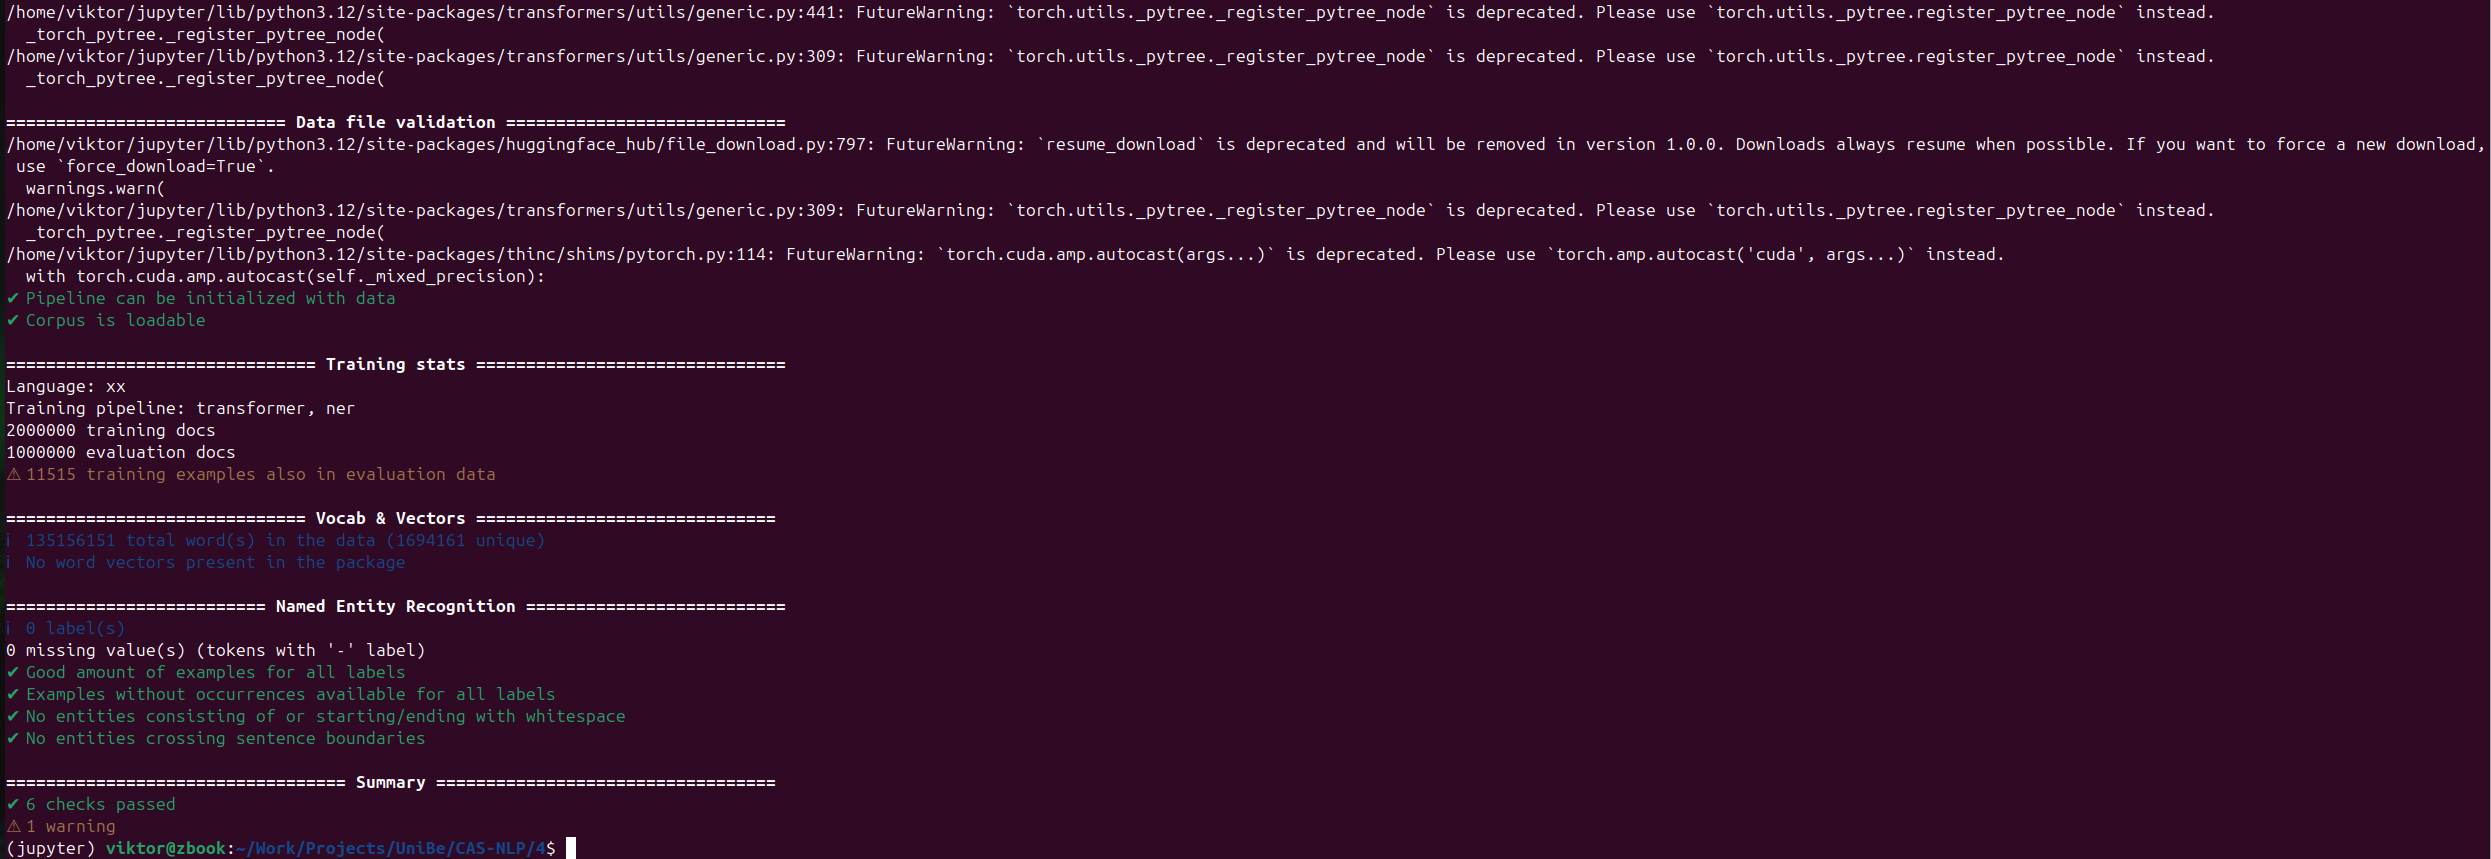

In [ ]:
# %run -m spacy train config.cfg --output ./ner_output --paths.train ./train --paths.dev ./validation --paths.test ./test --gpu-id 0

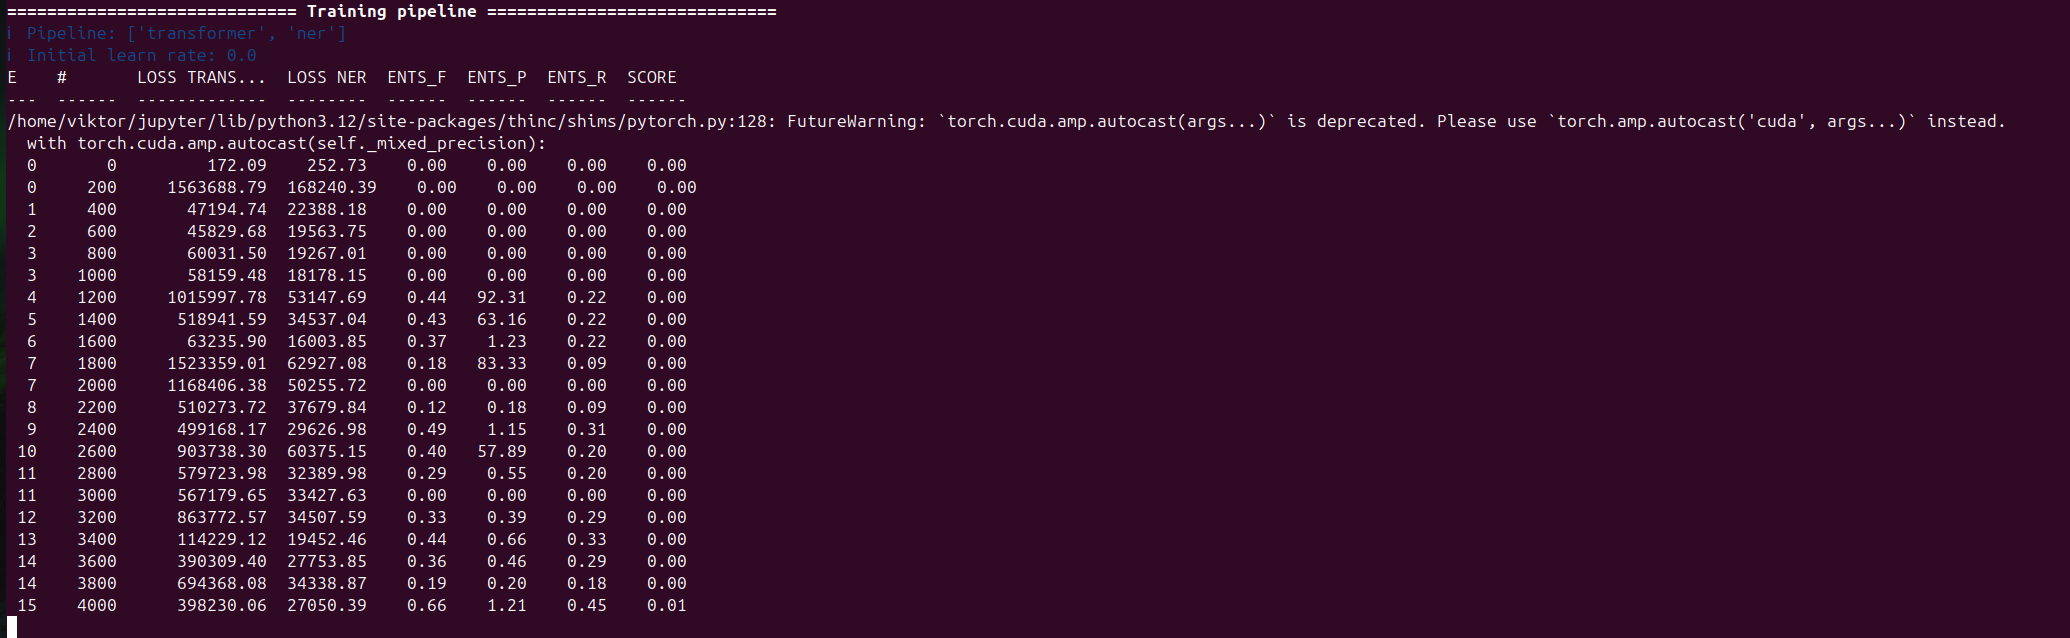

In [ ]:
import cupy
print(cupy.__version__)

# Check if GPU is available
print(cupy.cuda.runtime.getDeviceCount())

%run -m spacy train config.cfg --output ./ner_output --paths.train ./train --paths.dev ./validation --paths.test ./test --gpu-id 0

# Using Model

In [ ]:
model_trained = spacy.load(Path('model_en_3/model-best'))
print(model_trained.pipe_names)

ner_pipe = model_trained.get_pipe('ner')
print("NER labels:", ner_pipe.labels)

doc = model_trained(en_text)
print(doc.ents)

In [ ]:
print("\nText: ", en_text)
print('Entities: ', [(ent.text, ent.label_) for ent in doc.ents])

In [ ]:
#dir(spacy.load('xx_ent_wiki_sm'))

In [ ]:
for text, _ in test_ner[0:5]:
    doc = model_trained(text)
    print("\nText: ", text)
    print('Entities: ', [(ent.text, ent.label_) for ent in doc.ents])